In [1]:
from astropy.io import fits, ascii
from astropy.coordinates import SkyCoord, FK5
from astropy.wcs import WCS
from matplotlib.patches import Rectangle
from scipy import interpolate

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Correction for Dust Extinction

$m=M+5\log d - 5 + A_\lambda$

We need $A_\lambda$ to correct for dust extinction and we can get it if we have $\frac{A_\lambda}{A_\nu}$ and $A_\nu$.  

$\frac{A_\lambda}{A_\nu}$ comes from interpolating an extinction curve. 

$A_\nu$ comes from an extinction map. 

## Load New Swift UVOT Photometry

In [2]:
lmc_photometry = pd.read_csv("Data/Photometry/LMC_Reduced.csv"); 
lmc_photometry.head()

,name,obsid,ra,dec,uvw2_mag,uvw2_mag_err,uvm2_mag,uvm2_mag_err,uvw1_mag,uvw1_mag_err,...,mcps_flag,uvw2_key,uvw2_pix_x,uvw2_pix_y,uvm2_key,uvm2_pix_x,uvm2_pix_y,uvw1_key,uvw1_pix_x,uvw1_pix_y
0,lmc-obs45422-0,45422,86.287650,-68.71940,16.918753,0.078290,17.010029,0.095853,16.946421,0.089182,...,10.0,229.0,1335.778300,823.243841,246.0,1327.136584,830.466146,254.0,1326.155759,831.054911
1,lmc-obs45422-2,45422,86.300310,-68.73276,15.765285,0.055364,15.739356,0.062003,15.864105,0.059440,...,10.0,358.0,1318.849734,775.490093,373.0,1310.189633,782.758594,381.0,1309.218292,783.319538
2,lmc-obs45422-4,45422,86.307345,-68.73745,17.173498,0.088190,17.326818,0.111376,17.182741,0.103196,...,10.0,443.0,1309.546030,758.755247,457.0,1300.874822,766.040585,465.0,1299.909626,766.591268
3,lmc-obs45422-5,45422,86.311275,-68.72802,15.300091,0.050795,15.191233,0.054647,15.270247,0.051942,...,10.0,476.0,1304.762885,792.593007,490.0,1296.080545,799.873042,498.0,1295.124379,800.432650
4,lmc-obs45422-7,45422,86.319450,-68.73701,17.874832,0.126775,17.429226,0.117273,17.574596,0.129989,...,10.0,543.0,1293.834057,760.456145,556.0,1285.140376,767.761199,564.0,1284.189571,768.304755


## Get Sky Coordinates for Sources in Catalog

In [3]:
lmc_coords = SkyCoord(lmc_photometry['ra'],lmc_photometry['dec'],unit=(u.deg,u.deg),frame='fk5');
lmc_coords[0]

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (86.28765, -68.7194)>

## Get $A_\nu$ from hotav extinction map 

For the Magellanic Clouds I'm using the extinction maps which were created from the Zaritsky data. This was the original website but it has since been taken down: 
http://djuma.as.arizona.edu/~dennis/mcsurvey/Data_Products.html

Luckily I had a copy before it went down. The maps are "hotav" files, each pixel cooresponds to an A_V value at some position. 

Values of 0.0 denote null values rather than 0 extinction

In [4]:
lmc_av_file = "Data/DustMap/lmc_hotav.fits"
lmc_av_data = fits.open(lmc_av_file)[0].data
lmc_av_hdr = fits.open(lmc_av_file)[0].header
lmc_av_wcs = WCS(lmc_av_hdr)

In [5]:
x,y = lmc_coords.to_pixel(lmc_av_wcs)

# Pixel Position indices need to be integers. 
x = [int(np.round(x_)) for x_ in x]; y = [int(np.round(y_)) for y_ in y] 

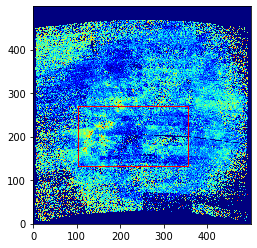

In [6]:
# What does the av file look like? Where in the image are we taking values from? 

fig,ax = plt.subplots(1)
ax.imshow(lmc_av_data,cmap="jet")
ax.invert_yaxis()
rect = Rectangle((min(x),min(y)),max(x)-min(x),max(y)-min(y),linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)

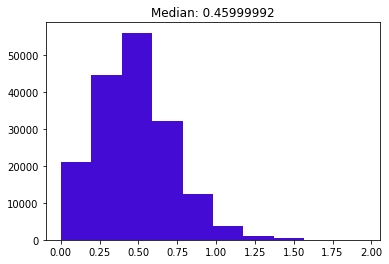

In [7]:
# Does the data make sense?
lmc_av_region = lmc_av_data[y,x]

plt.hist(lmc_av_region,color="#440BD4");
plt.title("Median: "+str(np.median(lmc_av_region)));

## Get $\frac{A_\lambda}{A_\nu}$ from interpolating an extinction curve. 

The extinction curves I'm using come from: http://www.stsci.edu/~kgordon/Dust/Extinction/MC_Ext/mc_ave_ext.html

You can see that this curve gives A_lambda/Av as a function of wavelength. So you just need to interpolate that to the wavelength of interest (i.e. the central wavelength of your filter) and multiply by the value of A_V that you looked up to get the extinction correction.

For the wavelengths I used the CTIO Effective wavelengths: http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?mode=browse&gname=Generic




In [8]:
effective_wavelengths = {
    "UVW2" : 2085.7 * u.Angstrom,
    "UVM2" : 2245.8 * u.Angstrom,
    "UVW1" : 2684.1 * u.Angstrom, 
    "U" : 3678.9* u.Angstrom,
    "B" : 4333.3 * u.Angstrom,
    "V" : 5321.6 * u.Angstrom,
    "I" : 8567.6 * u.Angstrom}

In [9]:
lmc_ext_curve = pd.read_csv("Data/ExtinctionCurve/lmc_avg_ext.dat",skiprows=7,sep="\s+",names=["wav_micron^-1","A(lambda)/A(V)","unc"])
lmc_ext_curve.head()

,wav_micron^-1,A(lambda)/A(V),unc
0,0.455,0.030434,0.001777
1,0.606,0.185884,0.008679
2,0.800,0.257140,0.011822
3,1.818,1.000000,0.017482
4,2.273,1.292860,0.085075


In [10]:
lmc_ext_curve_supershell = pd.read_csv("Data/ExtinctionCurve/lmc2_supershell_avg.dat",skiprows=7,sep="\s+",names=["wav_micron^-1","A(lambda)/A(V)","unc"])
lmc_ext_curve_supershell.head()

,wav_micron^-1,A(lambda)/A(V),unc
0,0.455,0.100997,0.008732
1,0.606,0.097109,0.008375
2,0.800,0.299096,0.023823
3,1.818,1.000000,0.030391
4,2.273,1.349010,0.148796


In [11]:
# Interpolate between points


def get_interpolated_gordon_function(gordon):
    wav = (np.array(1 / gordon["wav_micron^-1"]) * u.micron).to(u.Angstrom)
    ext = gordon["A(lambda)/A(V)"]

    interp_wav = np.arange(1500, 10000, 0.1)
    func = interpolate.interp1d(wav.value, ext)
    interp_ext = func(interp_wav)
    return wav, ext, interp_wav, interp_ext


(lmc_wav, lmc_ext, fit_lmc_wav, fit_lmc_ext) = get_interpolated_gordon_function(
    lmc_ext_curve
)

(
    lmc_wav_ss,
    lmc_ext_ss,
    fit_lmc_wav_ss,
    fit_lmc_ext_ss,
) = get_interpolated_gordon_function(lmc_ext_curve_supershell)

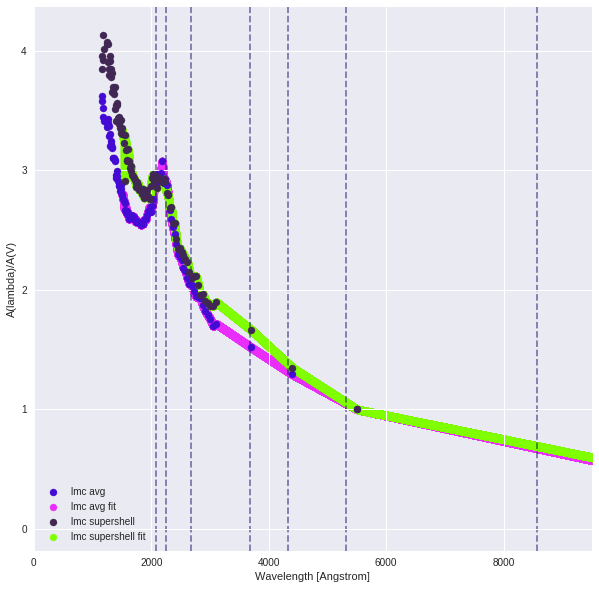

In [12]:
plt.figure(figsize=(10,10))
plt.style.use("seaborn")
#lmc avg
plt.scatter(lmc_wav,lmc_ext,c="#440BD4",s=50,label="lmc avg")
plt.scatter(fit_lmc_wav, fit_lmc_ext,c="#E92EFB",zorder=0,label="lmc avg fit")
#lmc supershell
plt.scatter(lmc_wav_ss,lmc_ext_ss,c="#412854",s=50,label="lmc supershell")
plt.scatter(fit_lmc_wav_ss,fit_lmc_ext_ss,c="#7FFF00",zorder=0,label="lmc supershell fit")

plt.xlabel("Wavelength [Angstrom]"); plt.ylabel("A(lambda)/A(V)")
[plt.axvline(effective_wavelengths[key].value,alpha=0.5,zorder=0,ls="--",c="#04005E") for key in effective_wavelengths]
plt.xlim(0,9500)
plt.legend();

In [13]:
def get_extinction_table(interp_wav,interp_ext,sname):
    ext = {}
    ext["Filter"] = ['UVW2','UVM2','UVW1','U','B','V','I']
    ext["Wav[A]"] = [effective_wavelengths[fltr].value for fltr in ext["Filter"]]
    ext["A(lambda)/A(V)"] = [interp_ext[np.where(np.isclose(ext["Wav[A]"][i],interp_wav))[0][0]] for i in range(7)]
    extinct = pd.DataFrame(ext)
    extinct.to_csv(sname,index=False)
    return extinct

In [14]:
# Save a table that has the extrapolated value for each filter. 
# Could do this for supershell as well, but I thought to stick with average at this point.

get_extinction_table(fit_lmc_wav, fit_lmc_ext,"Data/ExtinctionCurve/LMC_Average_Alambda_Av_Table.csv")

,Filter,Wav[A],A(lambda)/A(V)
0,UVW2,2085.7,2.931025
1,UVM2,2245.8,2.904411
2,UVW1,2684.1,2.041651
3,U,3678.9,1.524823
4,B,4333.3,1.314141
5,V,5321.6,1.047596
6,I,8567.6,0.674490


## We have both values now, so we can correct for extinction. 

In [15]:
Av = lmc_av_region
Alam_Av = pd.read_csv("Data/ExtinctionCurve/LMC_Average_Alambda_Av_Table.csv")

In [16]:
dered_UVW2 = lmc_photometry['uvw2_mag'] - (Av * Alam_Av["A(lambda)/A(V)"][0])
dered_UVM2 = lmc_photometry['uvm2_mag'] - (Av * Alam_Av["A(lambda)/A(V)"][1])
dered_UVW1 = lmc_photometry['uvw1_mag'] - (Av * Alam_Av["A(lambda)/A(V)"][2])
dered_U = lmc_photometry['Umag'] - (Av * Alam_Av["A(lambda)/A(V)"][3])
dered_B = lmc_photometry['Bmag'] - (Av * Alam_Av["A(lambda)/A(V)"][4])
dered_V = lmc_photometry['Vmag'] - (Av * Alam_Av["A(lambda)/A(V)"][5])
dered_I = lmc_photometry['Imag'] - (Av * Alam_Av["A(lambda)/A(V)"][6])

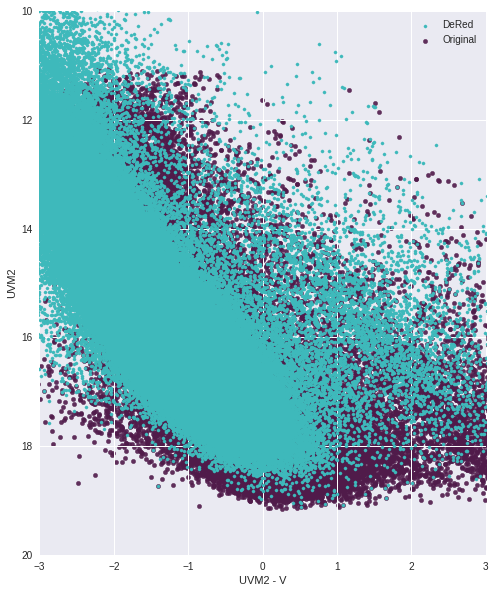

In [17]:
# How much has this changed things

plt.figure(figsize=(8,10))
plt.scatter(dered_UVM2 - dered_V,dered_UVM2,s=10,c="#3EB9BB",label="DeRed")
plt.scatter(lmc_photometry['uvm2_mag'] -lmc_photometry['Vmag'],lmc_photometry['uvm2_mag'],s=20,alpha=.9,zorder=0,c="#501B4A",label="Original")
plt.xlim(-3,3)
plt.ylim(20,10)
plt.legend()
plt.xlabel("UVM2 - V"); plt.ylabel("UVM2");


## Check Against MIST Catalog 

In [18]:
lmc_zams_AB = ascii.read("Data/MIST/ZAMS_Z0.006_ABmag.txt")

In [19]:
def Absolute_to_Apparent(mag,distance): 
    return mag + 5 * np.log10(distance) - 5

lmc_distance = 49.97 * 1000 #pc Pietrzynski 2013

In [20]:
lmc_zams_AB_UVM2 = Absolute_to_Apparent(lmc_zams_AB['UVM2_spec'],lmc_distance)
lmc_zams_AB_U = Absolute_to_Apparent(lmc_zams_AB['U_spec'],lmc_distance)
lmc_zams_AB_V = Absolute_to_Apparent(lmc_zams_AB['V_spec'],lmc_distance)

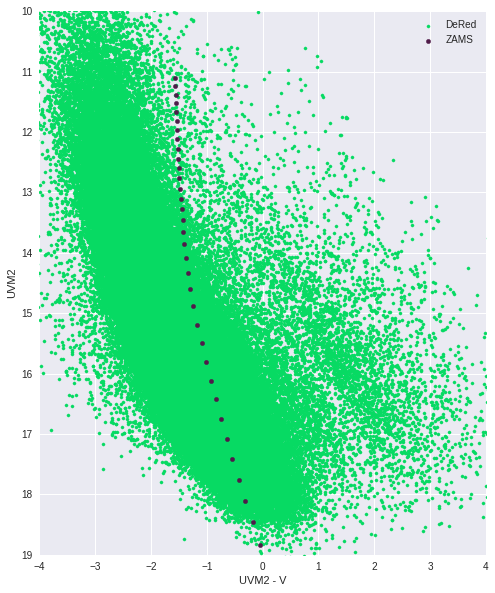

In [21]:
plt.figure(figsize=(8, 10))
plt.scatter(dered_UVM2 - dered_V, dered_UVM2, s=10, c="#07da63", label="DeRed")
plt.scatter(
    lmc_zams_AB_UVM2 - lmc_zams_AB_V,
    lmc_zams_AB_UVM2,
    s=20,
    zorder=10,
    c="#501B4A",
    label="ZAMS"
)
plt.xlim(-4,4)
plt.ylim(19,10)
plt.legend()
plt.xlabel("UVM2 - V")
plt.ylabel("UVM2");

## Is my photometry the issue?

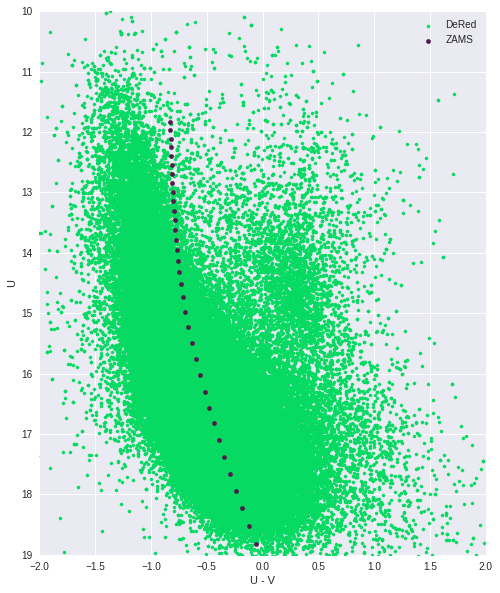

In [22]:
plt.figure(figsize=(8, 10))
plt.scatter(dered_U - dered_V, dered_U, s=10, c="#07da63", label="DeRed")
plt.scatter(
    lmc_zams_AB_U - lmc_zams_AB_V,
    lmc_zams_AB_U,
    s=20,
    zorder=10,
    c="#501B4A",
    label="ZAMS"
)
plt.xlim(-2,2)
plt.ylim(19,10)
plt.legend()
plt.xlabel("U - V")
plt.ylabel("U");